In [ ]:
## 1. Use permutation instead of combination
## 2. With itself is OK
## 3. Null card if no match

In [60]:
%load_ext autoreload
%autoreload 2

import os
import json

import numpy as np

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from collections import Counter

import wandb
wandb.login()
from pytorch_lightning.loggers import WandbLogger

from dataraw_sampling import sample_dataset, plot_sampled_distribution, sample_N_datapoints, decode_query_idx, encode_query_idx, queryidx_to_querypair, check_q1q2k_match
from dataraw_full_matrix import gen_card_data, report_gamedata_distribution
from util_distribution import plot_distribution, derive_game_setup_stats, get_distribution
from dataset import GameDatasetFromFullMatrix, GameTestFullDataset, GameDatasetTrainDataset
from datamodule import GameDataModule
from model import construct_full_model
from trainmodule import TrainModule

%matplotlib inline
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/app/Contrastive-Learning-Benchmarking/SecondPass-CardGame-experiments/contrastive_model.py:55: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('position_encoder', position_encoder,)
/app/Contrastive-Learning-Benchmarking/SecondPass-CardGame-experiments/contrastive_model.py:62: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  ('position_encoder', position_encoder,)


Generated 82 unqiue cards
Generated 6561 cardpairs
-- 5265 cardpairs with shared concept
-- 1296 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 2592), (2, 1944), (0, 1296), (3, 648), (4, 81)]
Total number of matches =  200961
Number of matches per key concept hit =  [(1, 165888), (2, 31104), (3, 2592), (0, 1296), (4, 81)]
------------------------
shape : (82, 6561)
size : 538002
sparsity : 0.3735320686540199
xy_rank : 82
xy_div_xyind_rank : 82
sum count table: 200961.0


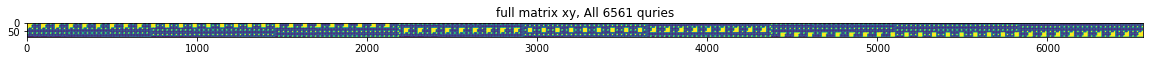

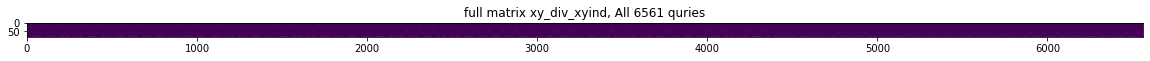

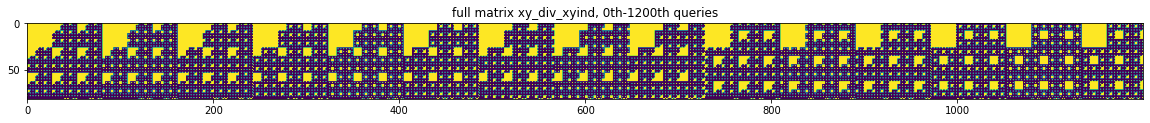

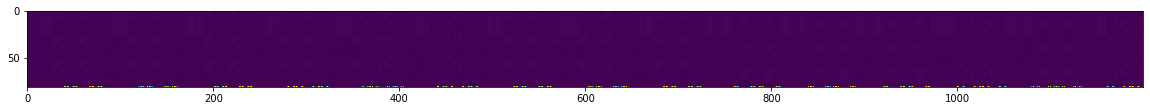

In [8]:
num_attributes = 4
num_attr_vals = 3
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)
for k in distribution:
    print(k,':', distribution[k])
plot_distribution(xy, xy_div_xyind, 'full matrix', figsize = (20,15), x_range_start=0, x_range_end=1200)
print('sum count table:', np.sum(count_table))

Generated 28 unqiue cards
Generated 729 cardpairs
-- 513 cardpairs with shared concept
-- 216 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 324), (0, 216), (2, 162), (3, 27)]
Total number of matches =  6075
Number of matches per key concept hit =  [(1, 5184), (2, 648), (0, 216), (3, 27)]
------------------------
shape : (28, 729)
size : 20412
sparsity : 0.2976190476190476
xy_rank : 28
xy_div_xyind_rank : 28
sum count table: 6075.0


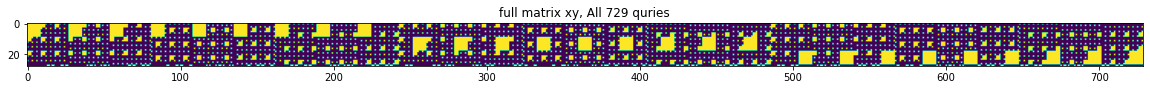

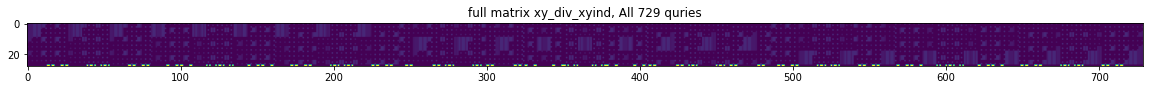

In [5]:
num_attributes = 3
num_attr_vals = 3
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)
for k in distribution:
    print(k,':', distribution[k])
plot_distribution(xy, xy_div_xyind, 'full matrix', figsize = (20,15), x_range_start=0, x_range_end=1200)
print('sum count table:', np.sum(count_table))

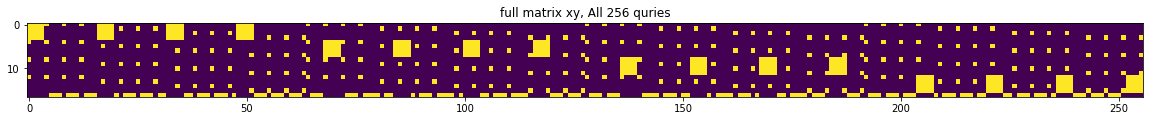

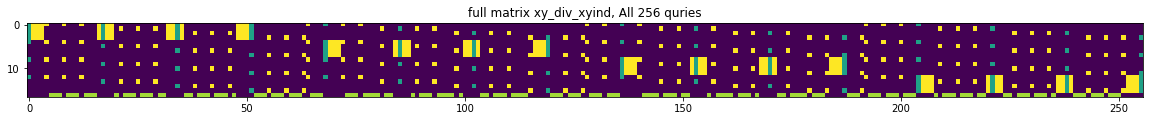

In [5]:
plot_distribution(xy, xy_div_xyind, 'full matrix', figsize = (20,15), x_range_start=2400, x_range_end=3600)

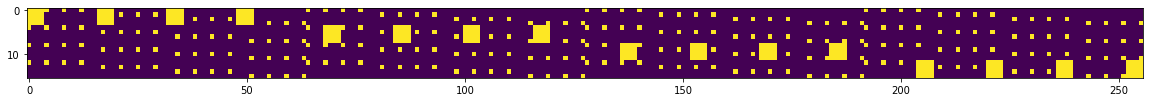

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
plt.imshow(xy[:-1, :])

In [15]:
np.linalg.matrix_rank(xy[:, :])

82

In [13]:
u, s, vh = np.linalg.svd(xy[:, :])

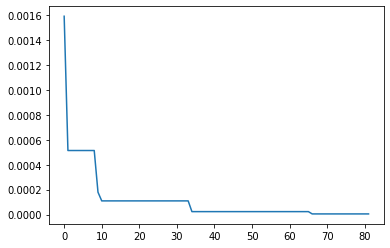

In [14]:
plt.plot(s)

In [6]:
np.linalg.matrix_rank(xy[:, :])

28

In [7]:
u, s, vh = np.linalg.svd(xy[:, :])

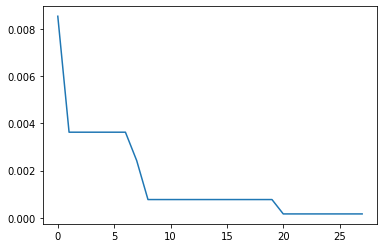

In [8]:
plt.plot(s)

In [9]:
s

array([0.00852637, 0.0036214 , 0.0036214 , 0.0036214 , 0.0036214 ,
       0.0036214 , 0.0036214 , 0.00241925, 0.00077208, 0.00077208,
       0.00077208, 0.00077208, 0.00077208, 0.00077208, 0.00077208,
       0.00077208, 0.00077208, 0.00077208, 0.00077208, 0.00077208,
       0.00016461, 0.00016461, 0.00016461, 0.00016461, 0.00016461,
       0.00016461, 0.00016461, 0.00016461])

Generated 82 unqiue cards
Generated 6561 cardpairs
-- 5265 cardpairs with shared concept
-- 1296 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 2592), (2, 1944), (0, 1296), (3, 648), (4, 81)]
Total number of matches =  200961
Number of matches per key concept hit =  [(1, 165888), (2, 31104), (3, 2592), (0, 1296), (4, 81)]
------------------------
shape : (82, 6561)
size : 538002
sparsity : 0.3735320686540199
xy_rank : 82
xy_div_xyind_rank : 82
sum count table: 200961.0


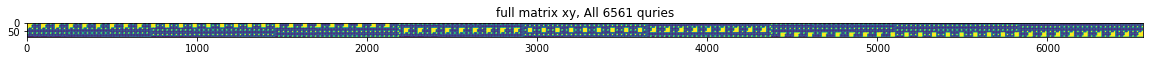

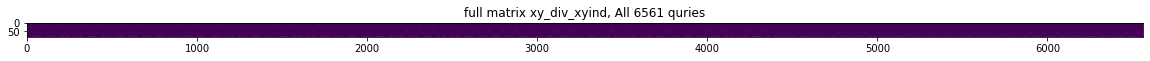

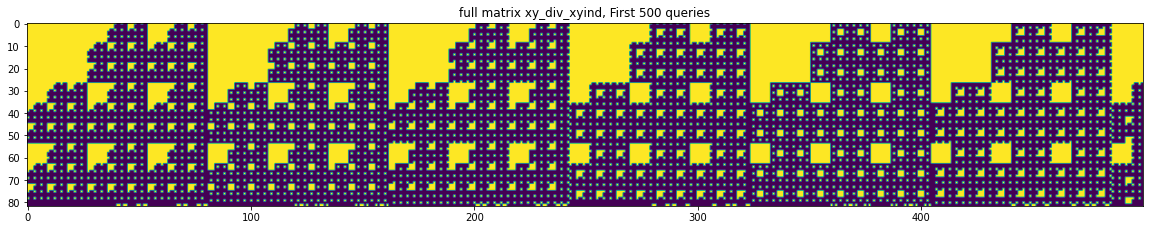

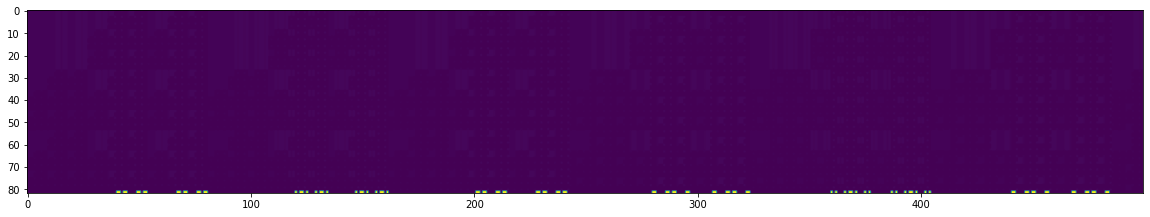

In [5]:
num_attributes = 4
num_attr_vals = 3
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)
for k in distribution:
    print(k,':', distribution[k])
plot_distribution(xy, xy_div_xyind, 'full matrix', figsize = (20,15), x_range=500)
print('sum count table:', np.sum(count_table))

## Derive Stats

In [7]:
derive_game_setup_stats(num_attributes=4, num_attr_vals=3)

{'num_cards': 82,
 'num_queries': 6561,
 'matrix_size': 538002,
 'total_matches': 200961,
 'sparsity': 0.3735320686540199,
 'total_queries_with_matches': 6561,
 'total_queries_with_real_matches': 5265,
 'percentage_queries_with_real_matches': 0.8024691358024691,
 'query_shared_attr_to_num_queries': {0: 1296,
  1: 2592,
  2: 1944,
  3: 648,
  4: 81},
 'query_shared_attr_to_num_matches': {0: 1, 1: 27, 2: 45, 3: 57, 4: 65},
 'query_shared_attr_to_total_num_matches': {0: 1296,
  1: 69984,
  2: 87480,
  3: 36936,
  4: 5265}}

In [63]:
2**100

1267650600228229401496703205376

## Sparsity Trend

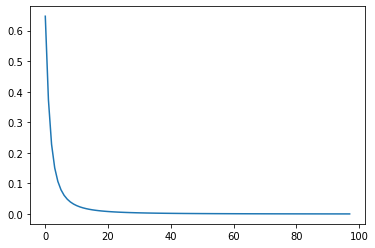

In [99]:
# Along number of attributes
sparsity = []
for i in range(2, 100):
    stats = derive_game_setup_stats(num_attributes=4, num_attr_vals=i)
    sparsity.append(stats['sparsity'])
    
plt.plot(sparsity)

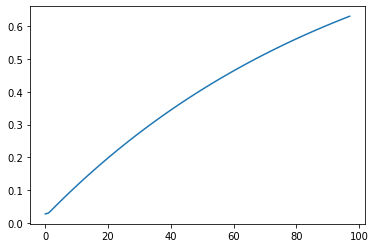

In [100]:
# Along number of dimensions
sparsity = []
for i in range(2, 100):
    stats = derive_game_setup_stats(num_attributes=i, num_attr_vals=10)
    sparsity.append(stats['sparsity'])
    
plt.plot(sparsity)

In [8]:
stats = derive_game_setup_stats(num_attributes=8, num_attr_vals=128)
stats

{'num_cards': 72057594037927937,
 'num_queries': 5192296858534827628530496329220096,
 'matrix_size': 374144419156711152252440175710196081562415060221952,
 'total_matches': 182648683125860006559126142027117298041588023296,
 'sparsity': 0.0004881769546036105,
 'total_queries_with_matches': 5192296858534827628530496329220096,
 'total_queries_with_real_matches': 315782303173809002019809635860480,
 'percentage_queries_with_real_matches': 0.06081745935900072,
 'query_shared_attr_to_num_queries': {0: 4876514555361018626510686693359616,
  1: 307182019235339756000673177534464,
  2: 8465646199399127133876819853312,
  3: 133317262982663419431131021312,
  4: 1312177785262435230621368320,
  5: 8265686836298804602339328,
  6: 32542074158656711032832,
  7: 73210515542534782976,
  8: 72057594037927936},
 'query_shared_attr_to_num_matches': {0: 1,
  1: 562949953421312,
  2: 1121501860331520,
  3: 1675690080468992,
  4: 2225548705136640,
  5: 2771111559299072,
  6: 3312412203663360,
  7: 384948393674355

## Sampling

100%|██████████| 10000/10000 [00:00<00:00, 16890.29it/s]


Sparsity Estimate: 0.23592695701410843


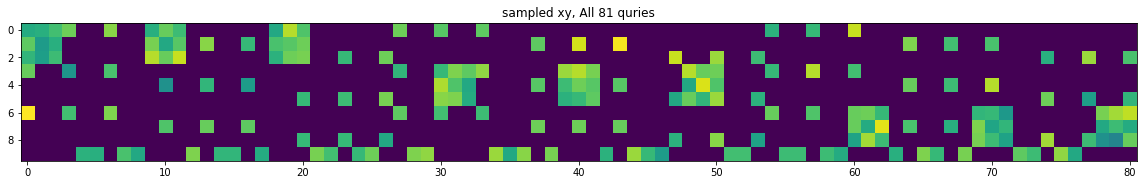

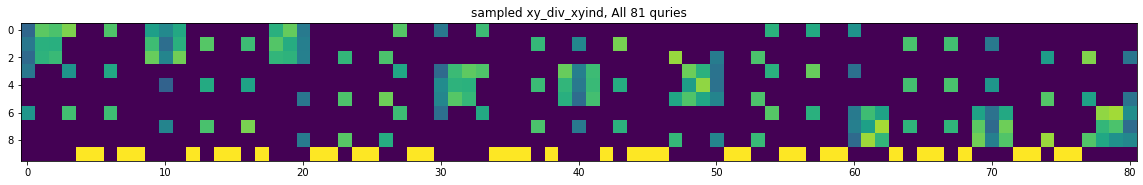

In [15]:
datapoints, sparsity_estimate = sample_N_datapoints(num_attrs=2, num_attr_vals=3, N=10000)

count_table = np.zeros((3**2+1, 3**2*3**2))
for q, k in datapoints:
    count_table[k, q] += 1
    
xy, xyind, xy_div_xyind = get_distribution(count_table, distribution_epsilon=0.0)
plot_distribution(xy, xy_div_xyind, 'sampled', figsize=(20,15))

Generated 10 unqiue cards
Generated 81 cardpairs
-- 45 cardpairs with shared concept
-- 36 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 36), (0, 36), (2, 9)]
Total number of matches =  189
Number of matches per key concept hit =  [(1, 144), (0, 36), (2, 9)]
------------------------
{'shape': (10, 81), 'size': 810, 'sparsity': 0.23333333333333334, 'xy_rank': 10, 'xy_div_xyind_rank': 10}
Full
First 300 queries


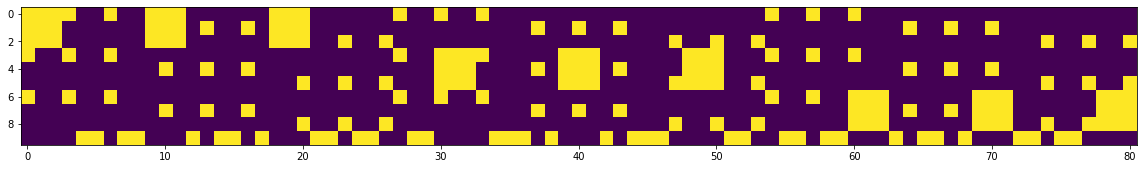

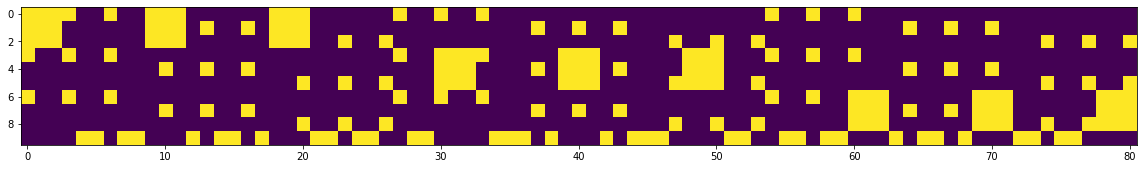

In [126]:
num_attributes = 2
num_attr_vals = 3
game_data = gen_card_data(attributes, attr_order, num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)
print(distribution)
plot_distribution(xy, xy_div_xyind, figsize = (20,15))

In [18]:
2**23 / 128

65536.0

## Scrap

In [8]:
num_attributes = 3
num_attr_vals = 4
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)
distribution

Generated 65 unqiue cards
Generated 4096 cardpairs
-- 2368 cardpairs with shared concept
-- 1728 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 1728), (0, 1728), (2, 576), (3, 64)]
Total number of matches =  47872
Number of matches per key concept hit =  [(1, 43200), (2, 2880), (0, 1728), (3, 64)]
------------------------


{'shape': (65, 4096),
 'size': 266240,
 'sparsity': 0.1798076923076923,
 'xy_rank': 65,
 'xy_div_xyind_rank': 65}

full matrix rank =  65
[(7.0, 27), (0.0, 15), (1.0, 12), (57.0, 7), (56.0, 2), (123.0, 1), (41.0, 1)]
s:
 [123.84264209  57.          57.          57.          57.
  57.          57.          57.          57.          57.
  41.56921938   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.        ]


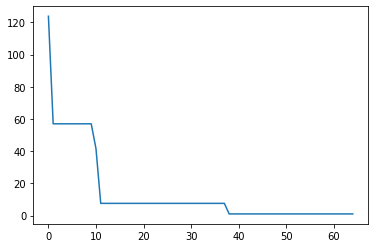

In [9]:
# full
print('full matrix rank = ', np.linalg.matrix_rank(count_table))
u,s,vh = np.linalg.svd(count_table)
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

## Rank Study

In [4]:
num_attributes = 3
num_attr_vals = 4
game_data = gen_card_data(num_attributes, num_attr_vals, num_unseen_cardpairs=0, debug=False)
print('------------------------')
count_table, xy, xyind, xy_div_xyind, distribution = report_gamedata_distribution(game_data, distribution_epsilon=1e-100)
distribution

Generated 65 unqiue cards
Generated 4096 cardpairs
-- 2368 cardpairs with shared concept
-- 1728 cardpairs without shared concept
Number of cardpairs per shared concept [(1, 1728), (0, 1728), (2, 576), (3, 64)]
Total number of matches =  47872
Number of matches per key concept hit =  [(1, 43200), (2, 2880), (0, 1728), (3, 64)]
------------------------


{'shape': (65, 4096),
 'size': 266240,
 'sparsity': 0.1798076923076923,
 'xy_rank': 65,
 'xy_div_xyind_rank': 65}

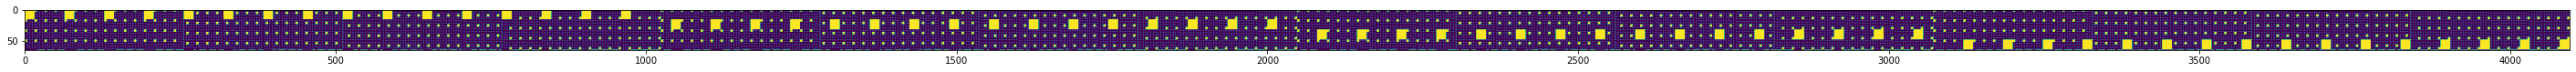

In [183]:
plt.figure(figsize = (50,10))
plt.imshow((count_table))

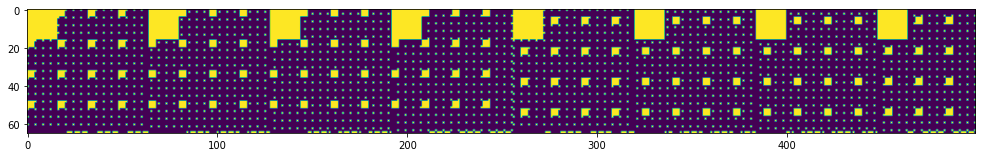

In [192]:
plt.figure(figsize = (17,25))
plt.imshow((count_table[:,:500]))

full matrix rank =  65
[(7.0, 27), (0.0, 15), (1.0, 12), (57.0, 7), (56.0, 2), (123.0, 1), (41.0, 1)]
s:
 [123.84264209  57.          57.          57.          57.
  57.          57.          57.          57.          57.
  41.56921938   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   7.54983444   7.54983444
   7.54983444   7.54983444   7.54983444   1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.        ]


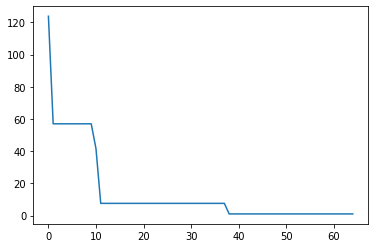

In [10]:
# full
print('full matrix rank = ', np.linalg.matrix_rank(count_table))
u,s,vh = np.linalg.svd(count_table)
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [11]:
# filter to no same cards
keep_queries = []
seen = []
for i in range((num_attr_vals**num_attributes)**2):
    card1idx, card2idx = decode_query_idx(num_attributes, num_attr_vals, i)
    if card1idx != card2idx:
        keep_queries.append(True)
        seen.append((card1idx, card2idx))
    else:
        keep_queries.append(False)

no same queries matrix rank =  38
[(6.0, 27), (0.0, 27), (56.0, 9), (118.0, 1), (41.0, 1)]
s:
 [1.18186294e+02 5.62849891e+01 5.62849891e+01 5.62849891e+01
 5.62849891e+01 5.62849891e+01 5.62849891e+01 5.62849891e+01
 5.62849891e+01 5.62849891e+01 4.15692194e+01 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 1.44309550e-13 1.08377792e-13
 1.03675286e-13 7.67666251e-14 7.23964616e-14 7.19717588e-14
 6.45850157e-14 5.38965107e-14 4.17643872e-14 3.15796430e-14
 3.09600345e-14 2.38919989e-14 2.10511413e-14 2.03404679e-14
 1.98526557e-14 1.62496752e-14 1.60769929e-14 1.18113924e-14
 1.16524347e-14 9.72184360e-15 8.06923980e-15 8.069

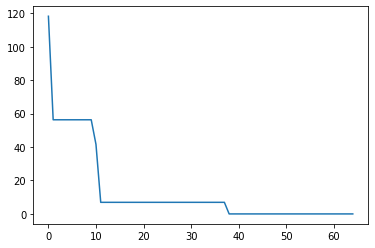

In [12]:
# filter to no same cards
print('no same queries matrix rank = ', np.linalg.matrix_rank(count_table[:,keep_queries]))
u,s,vh = np.linalg.svd(count_table[:,keep_queries])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

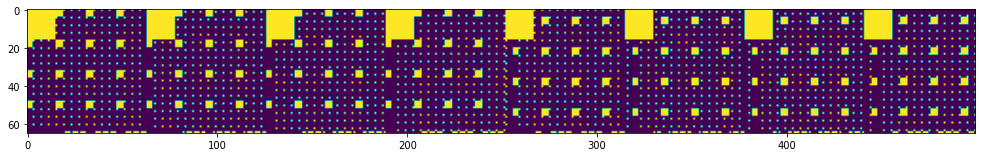

In [13]:
plt.figure(figsize = (17,25))
plt.imshow((count_table[:,keep_queries][:,:500]))

In [14]:
# filter to queries with 3 shared attributes
keep_queries3 = []
seen = []
for i in range((num_attr_vals**num_attributes)**2):
    card1idx, card2idx = decode_query_idx(num_attributes, num_attr_vals, i)
    if card1idx == card2idx:
        keep_queries3.append(True)
        seen.append((card1idx, card2idx))
    else:
        keep_queries3.append(False)

no same queries matrix rank =  64
[(0.0, 16), (2.0, 15), (3.0, 12), (1.0, 11), (8.0, 5), (9.0, 4), (36.0, 1)]
s:
 [37.  9.  9.  9.  9.  9.  9.  9.  9.  9.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


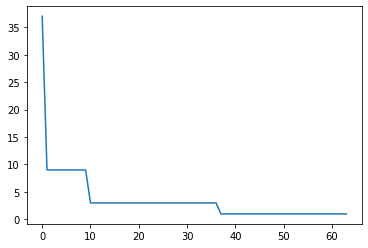

In [21]:
# filter to queries with 3 shared attributes
print('no same queries matrix rank = ', np.linalg.matrix_rank(count_table[:,keep_queries3]))
u,s,vh = np.linalg.svd(count_table[:,keep_queries3])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [27]:
np.sum(count_table[:,keep_queries3])

2368.0

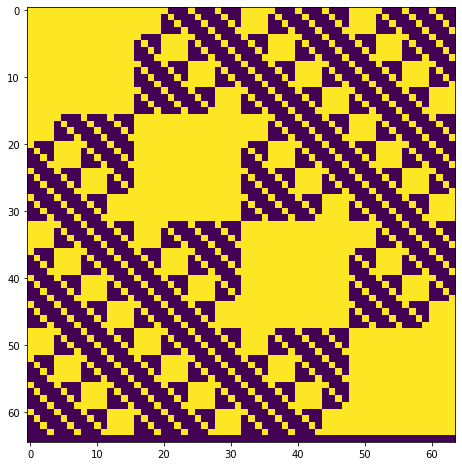

In [217]:
plt.figure(figsize = (8,8))
plt.imshow((count_table[:,keep_queries3]))

In [29]:
# filter to queries with 3 shared attributes
# filter to only keys with 1 hit

keep_querykeys31 = np.zeros(count_table.shape)

for i in range(count_table.shape[1]):
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 3: 
        for j in range(count_table.shape[0]):
            num_matches = check_q1q2k_match(num_attributes, num_attr_vals, card1, card2, j)
            if num_matches == 1:
                keep_querykeys31[j, i] = 1.0

In [30]:
len(s) - 28

36

no same queries matrix rank =  64
[(3.0, 20), (5.0, 19), (2.0, 16), (4.0, 8), (27.0, 1)]
s:
 [27.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.  5.  5.  5.  5.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  3.  3.  3.  3.]


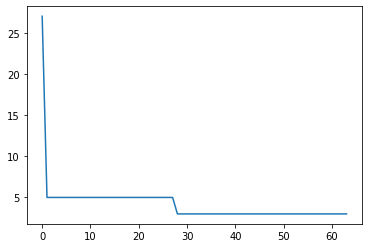

In [31]:
# filter to queries with 3 shared attributes
# filter to only keys with 1 hit

print('no same queries matrix rank = ', np.linalg.matrix_rank((count_table * keep_querykeys31)[:,keep_queries3]))
u,s,vh = np.linalg.svd((count_table * keep_querykeys31)[:,keep_queries3])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [32]:
np.sum((count_table * keep_querykeys31)[:,keep_queries3])

1728.0

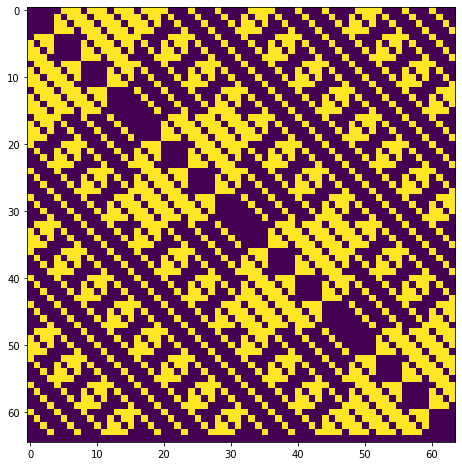

In [282]:
plt.figure(figsize = (8,8))
plt.imshow(((count_table * keep_querykeys31)[:,keep_queries3]))

In [23]:
# filter to queries with 3 shared attributes
# filter to only keys with 2 hit

keep_querykeys32 = np.zeros(count_table.shape)

for i in range(count_table.shape[1]):
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 3: 
        for j in range(count_table.shape[0]):
            num_matches = check_q1q2k_match(num_attributes, num_attr_vals, card1, card2, j)
            if num_matches == 2:
                keep_querykeys32[j, i] = 1.0

no same queries matrix rank =  64
[(2.0, 17), (1.0, 15), (0.0, 12), (3.0, 10), (5.0, 6), (4.0, 3), (8.0, 1)]
s:
 [9. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


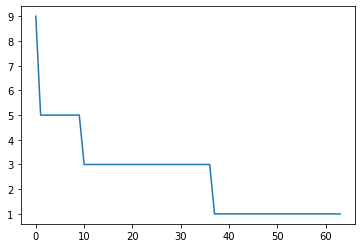

In [24]:
# filter to queries with 3 shared attributes
# filter to only keys with 2 hit

print('no same queries matrix rank = ', np.linalg.matrix_rank((count_table * keep_querykeys32)[:,keep_queries3]))
u,s,vh = np.linalg.svd((count_table * keep_querykeys32)[:,keep_queries3])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [33]:
np.sum((count_table * keep_querykeys32)[:,keep_queries3])

576.0

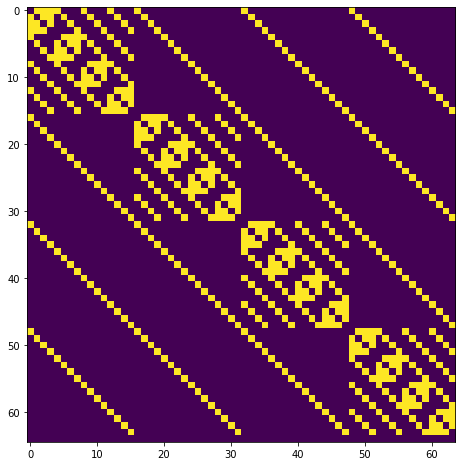

In [25]:
plt.figure(figsize = (8,8))
plt.imshow(((count_table * keep_querykeys32)[:,keep_queries3]))

In [34]:
# filter to queries with 3 shared attributes
# filter to only keys with 3 hit

keep_querykeys33 = np.zeros(count_table.shape)

for i in range(count_table.shape[1]):
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 3: 
        for j in range(count_table.shape[0]):
            num_matches = check_q1q2k_match(num_attributes, num_attr_vals, card1, card2, j)
            if num_matches == 3:
                keep_querykeys33[j, i] = 1.0

no same queries matrix rank =  64
[(1.0, 64)]
s:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


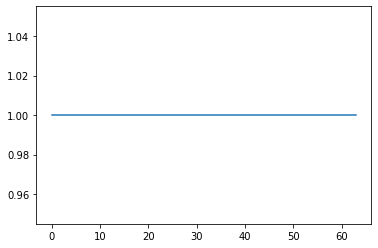

In [35]:
# filter to queries with 3 shared attributes
# filter to only keys with 3 hit

print('no same queries matrix rank = ', np.linalg.matrix_rank((count_table * keep_querykeys33)[:,keep_queries3]))
u,s,vh = np.linalg.svd((count_table * keep_querykeys33)[:,keep_queries3])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [37]:
np.sum((count_table * keep_querykeys33)[:,keep_queries3])

64.0

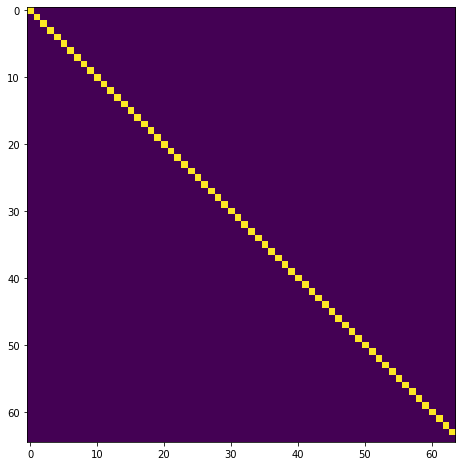

In [36]:
plt.figure(figsize = (8,8))
plt.imshow(((count_table * keep_querykeys33)[:,keep_queries3]))

In [41]:
# filter to queries with 2 shared attributes

keep_queries2 = []
seen = []
for i in range((num_attr_vals**num_attributes)**2):
#     card1idx, card2idx = decode_query_idx(num_attributes, num_attr_vals, i)
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 2:
        keep_queries2.append(True)
        seen.append((card1idx, card2idx))
    else:
        keep_queries2.append(False)

In [244]:
keep_queries3 == keep_queries2

False

In [47]:
np.sum(count_table[:,keep_queries2])

16128.0

no same queries matrix rank =  37
[(0.0, 28), (6.0, 27), (29.0, 9), (84.0, 1)]
s:
 [8.40000000e+01 2.93938769e+01 2.93938769e+01 2.93938769e+01
 2.93938769e+01 2.93938769e+01 2.93938769e+01 2.93938769e+01
 2.93938769e+01 2.93938769e+01 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 7.75540042e-14 4.37030998e-14 3.71786008e-14
 2.08321100e-14 1.54388779e-14 1.37398166e-14 1.23538893e-14
 9.32959307e-15 8.75690664e-15 7.96447600e-15 6.26507516e-15
 5.91762114e-15 5.91762114e-15 5.91762114e-15 5.91762114e-15
 5.91762114e-15 5.91762114e-15 5.91762114e-15 5.91762114e-15
 5.91762114e-15 5.91762114e-15 5.91762114e-15 5.91762114e-15
 5

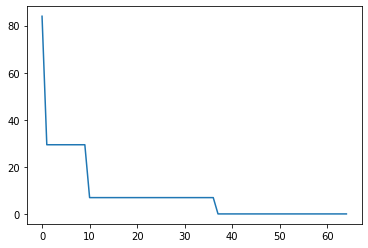

In [245]:
# filter to queries with 2 shared attributes
print('no same queries matrix rank = ', np.linalg.matrix_rank(count_table[:,keep_queries2]))
u,s,vh = np.linalg.svd(count_table[:,keep_queries2])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

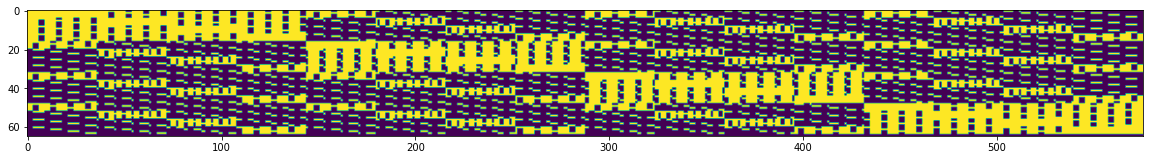

In [256]:
plt.figure(figsize = (20,8))
plt.imshow((count_table[:,keep_queries2]))

In [39]:
# filter to queries with 2 shared attributes
# filter to only keys with 1 hit

keep_querykeys21 = np.zeros(count_table.shape)

for i in range(count_table.shape[1]):
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 2: 
        for j in range(count_table.shape[0]):
            num_matches = check_q1q2k_match(num_attributes, num_attr_vals, card1, card2, j)
            if num_matches == 1:
                keep_querykeys21[j, i] = 1.0

In [45]:
np.sum((count_table * keep_querykeys21)[:,keep_queries2])

13824.0

no same queries matrix rank =  37
[(0.0, 28), (13.0, 27), (19.0, 9), (72.0, 1)]
s:
 [7.20000000e+01 1.95959179e+01 1.95959179e+01 1.95959179e+01
 1.95959179e+01 1.95959179e+01 1.95959179e+01 1.95959179e+01
 1.95959179e+01 1.95959179e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 1.38564065e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 1.38564065e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 1.38564065e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 1.38564065e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 1.38564065e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 1.38564065e+01 1.38564065e+01 1.38564065e+01
 1.38564065e+01 8.11049445e-14 3.61117672e-14 2.28574456e-14
 1.91771609e-14 1.73924807e-14 1.55309054e-14 1.25828986e-14
 1.23069612e-14 1.19256891e-14 1.14502498e-14 1.12946051e-14
 9.97631826e-15 8.70624296e-15 8.24112325e-15 8.12826170e-15
 7.80711919e-15 7.78224542e-15 7.12443936e-15 6.72707036e-15
 6.44385296e-15 6.40152675e-15 6.18707528e-15 6.13487318e-15
 

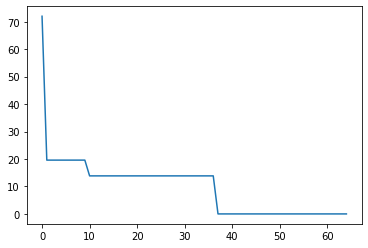

In [42]:
# filter to queries with 2 shared attributes
# filter to only keys with 2 hit

print('no same queries matrix rank = ', np.linalg.matrix_rank((count_table * keep_querykeys21)[:,keep_queries2]))
u,s,vh = np.linalg.svd((count_table * keep_querykeys21)[:,keep_queries2])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

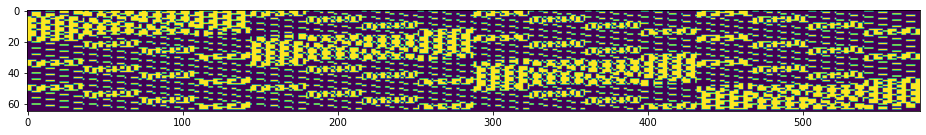

In [299]:
plt.figure(figsize = (16,16))
plt.imshow(((count_table * keep_querykeys21)[:,keep_queries2]))

In [49]:
# filter to queries with 2 shared attributes
# filter to only keys with 2 hit

keep_querykeys22 = np.zeros(count_table.shape)

for i in range(count_table.shape[1]):
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 2: 
        for j in range(count_table.shape[0]):
            num_matches = check_q1q2k_match(num_attributes, num_attr_vals, card1, card2, j)
            if num_matches == 2:
                keep_querykeys22[j, i] = 1.0

no same queries matrix rank =  37
[(0.0, 28), (6.0, 27), (9.0, 9), (12.0, 1)]
s:
 [1.20000000e+01 9.79795897e+00 9.79795897e+00 9.79795897e+00
 9.79795897e+00 9.79795897e+00 9.79795897e+00 9.79795897e+00
 9.79795897e+00 9.79795897e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 6.92820323e+00 6.92820323e+00 6.92820323e+00
 6.92820323e+00 1.57657411e-14 1.06581410e-14 1.06575227e-14
 1.02455794e-14 9.51378674e-15 7.90667154e-15 7.73329283e-15
 7.64414697e-15 6.05960921e-15 5.55055768e-15 4.92943317e-15
 4.47967063e-15 4.18502389e-15 4.13051498e-15 4.10487514e-15
 3.82834011e-15 3.43185096e-15 3.18184377e-15 2.83543854e-15
 2.83047658e-15 2.64088444e-15 2.54054341e-15 2.52959235e-15
 2.

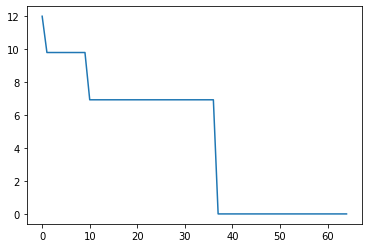

In [50]:
# filter to queries with 2 shared attributes
# filter to only keys with 2 hit

print('no same queries matrix rank = ', np.linalg.matrix_rank((count_table * keep_querykeys22)[:,keep_queries2]))
u,s,vh = np.linalg.svd((count_table * keep_querykeys22)[:,keep_queries2])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [51]:
np.sum((count_table * keep_querykeys22)[:,keep_queries2])

2304.0

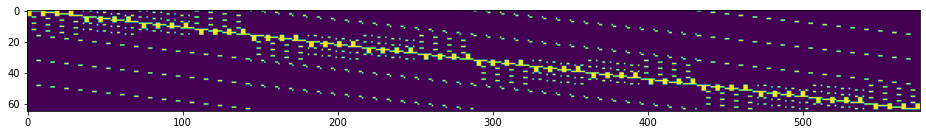

In [296]:
plt.figure(figsize = (16,16))
plt.imshow(((count_table * keep_querykeys22)[:,keep_queries2]))

In [53]:
# filter to queries with 1 shared attributes

keep_queries1 = []
seen = []
for i in range((num_attr_vals**num_attributes)**2):
#     card1idx, card2idx = decode_query_idx(num_attributes, num_attr_vals, i)
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 1:
        keep_queries1.append(True)
        seen.append((card1idx, card2idx))
    else:
        keep_queries1.append(False)

no same queries matrix rank =  10
[(0.0, 55), (47.0, 6), (48.0, 3), (83.0, 1)]
s:
 [8.31384388e+01 4.80000000e+01 4.80000000e+01 4.80000000e+01
 4.80000000e+01 4.80000000e+01 4.80000000e+01 4.80000000e+01
 4.80000000e+01 4.80000000e+01 2.49563485e-13 1.99088289e-13
 1.80033396e-13 1.64795549e-13 1.50287150e-13 1.24713951e-13
 1.17787268e-13 1.13112227e-13 1.05095262e-13 9.16789204e-14
 8.01552526e-14 7.27036797e-14 4.52888756e-14 4.07993247e-14
 3.81837298e-14 2.82117185e-14 2.62523979e-14 2.02085345e-14
 1.64972865e-14 1.29020031e-14 1.06751082e-14 9.60104232e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6.78279942e-15 6.78279942e-15 6.78279942e-15 6.78279942e-15
 6

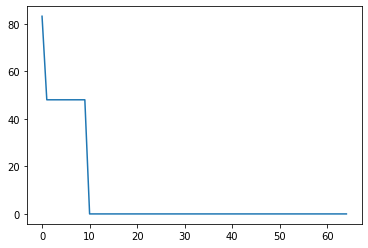

In [54]:
# filter to queries with 1 shared attributes
print('no same queries matrix rank = ', np.linalg.matrix_rank(count_table[:,keep_queries1]))
u,s,vh = np.linalg.svd(count_table[:,keep_queries1])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [55]:
np.sum(count_table[:,keep_queries1])

27648.0

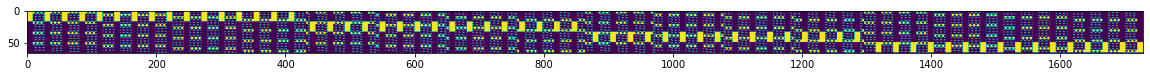

In [255]:
plt.figure(figsize = (20,8))
plt.imshow((count_table[:,keep_queries1]))

In [57]:
# filter to queries with 0 shared attributes

keep_queries0 = []
seen = []
for i in range((num_attr_vals**num_attributes)**2):
#     card1idx, card2idx = decode_query_idx(num_attributes, num_attr_vals, i)
    card1, card2 = queryidx_to_querypair(num_attributes, num_attr_vals, i)
    if np.sum(card1 == card2) == 0:
        keep_queries0.append(True)
        seen.append((card1idx, card2idx))
    else:
        keep_queries0.append(False)

no same queries matrix rank =  1
[(0.0, 64), (41.0, 1)]
s:
 [4.15692194e+01 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.15239738e-15 4.15239738e-15 4.15239738e-15
 4.15239738e-15 4.1523973

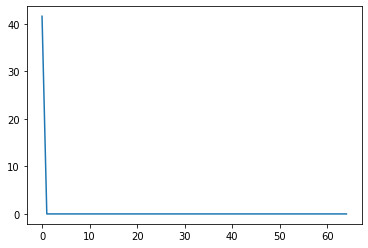

In [58]:
# filter to queries with 1 shared attributes
print('no same queries matrix rank = ', np.linalg.matrix_rank(count_table[:,keep_queries0]))
u,s,vh = np.linalg.svd(count_table[:,keep_queries0])
print(Counter(list(s//1)).most_common())
plt.plot(s)
print('s:\n',s)

In [59]:
np.sum(count_table[:,keep_queries0])

1728.0

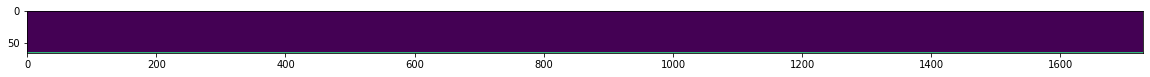

In [259]:
plt.figure(figsize = (20,8))
plt.imshow((count_table[:,keep_queries0]))

In [ ]:
# ToDo

# Document why Rank was Wrong
# Document how to figure out rank for one game level
# Construct Table of difficulty level vs rank for all scenarios